# Notebook to implement and test the disk field of UF23 Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

### General Constants

In [2]:
kPi = math.pi
kTwoPi = 2 * kPi
degree = kPi / 180.
kpc = 1
microgauss = 1
megayear = 1
Gpc = 1e6 * kpc
pc = 1e-3 * kpc
second = megayear / (1e6 * 60 * 60 * 24 * 365.25)
kilometer = kpc / 3.0856775807e+16

Parameters for neCl Model:

In [3]:
fDiskB1        =  1.4259645e+00 * microgauss
fDiskB2        =  1.3543223e+00 * microgauss
fDiskB3        =  3.4390669e+00 * microgauss
fDiskH         =  6.7405199e-01 * kpc
fDiskPhase1    =  1.9961898e+02 * degree
fDiskPhase2    =  1.3541461e+02 * degree
fDiskPhase3    =  6.4909767e+01 * degree
fDiskPitch     =  1.1867859e+01 * degree
fDiskW         =  6.1162799e-02 * kpc
fPoloidalB     =  9.8387831e-01 * microgauss
fPoloidalP     =  1.6773615e+00 * kpc
fPoloidalR     =  7.4084361e+00 * kpc
fPoloidalW     =  1.4168192e-01 * kpc
fPoloidalZ     =  3.6521188e+00 * kpc
fStriation     =  3.3600213e-01
fToroidalBN    =  2.6256593e+00 * microgauss
fToroidalBS    = -2.5699466e+00 * microgauss
fToroidalR     =  1.0134257e+01 * kpc
fToroidalW     =  1.1547728e+00 * kpc
fToroidalZ     =  4.5585463e+00 * kpc

fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

## General functions

In [4]:
def sigmoid(x, x0, w):
    """Logistic sigmoid function."""
    return 1 / (1 + np.exp(-(x - x0) / w))

# Not sure about this function
def cyl_to_cart(v, cos_phi, sin_phi):
    """
    Converts a given vector v in cylinder coordinates
    to cartesian coordinates
    """
    return np.array([v[0] * cos_phi - v[1] * sin_phi,
                     v[0] * sin_phi + v[1] * cos_phi,
                     v[2]]) 

# returns the sign of b-field depending on quadrant for plotting
def sign(b, x, y):
    if x>0 and y>0:
        return 1 if b[1]>0 else -1
    elif x<0 and y<0:
        return -1 if b[1]>0 else 1
    elif x>0 and y<0:
        return 1 if b[0]>0 else -1
    else:
        return -1 if b[0]>0 else 1

## Fourier-Spiral disk field

In [5]:
def get_spiral_field(x, y, z):
    # reference radius
    r_ref = 5 * kpc
    # inner boundary of spiral field, w = transition width
    r_inner = 5 * kpc
    w_inner = 0.5 * kpc
    # outer boundary of spiral field
    r_outer = 20 * kpc
    w_outer = 0.5 * kpc
    
    #cylindrical coordinates
    r2 = x**2 + y**2
    if r2 == 0:
        return np.array([0, 0, 0])

    r = np.sqrt(r2)
    phi = np.arctan2(y, x)

    # Eq. (13)
    hdz = 1 - sigmoid(abs(z), fDiskH, fDiskW)
    
    # Eq. (14) time r_ref divided by r
    r_fac_i = sigmoid(r, r_inner, w_inner)
    r_fac_o = 1 - sigmoid(r, r_outer, w_outer)
    # (using lim r--> 0 (1-exp(-r^2))/r --> r - r^3/2 + ...)
    if r > 1e-5 * kpc:
        r_fac = (1 - np.exp(-r * r)) / r
    else:
        r * (1 - r2 / 2)
    gdr_times_rref_by_r = r_ref * r_fac * r_fac_o * r_fac_i
    
    # Eq. (12)
    phi0 = phi - np.log(r / r_ref) / fTanPitch

    # Eq. (10)
    b = (fDiskB1 * np.cos(1 * (phi0 - fDiskPhase1)) +
         fDiskB2 * np.cos(2 * (phi0 - fDiskPhase2)) +
         fDiskB3 * np.cos(3 * (phi0 - fDiskPhase3)))

    # Eq. (11)
    fac = hdz * gdr_times_rref_by_r
    b_cyl = np.array([b * fac * fSinPitch,
                      b * fac * fCosPitch,
                      0])

    cos_phi = x / r
    sin_phi = y / r
    return cyl_to_cart(b_cyl, cos_phi, sin_phi)

### Plotting

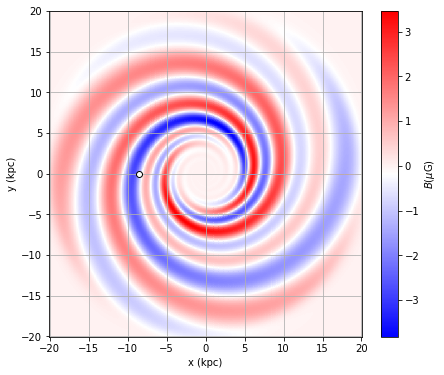

In [6]:
z = 0

# grid of x and y values
x = np.linspace(-20, 20, 501)
y = np.linspace(-20, 20, 501)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_spiral_field(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()